# Project 1: Weather Trends

## Step 1: Data extraction

The first step was to get the data from the database. The city I was closest to at the moment (and that had the data) was Kiev. The following queries were used: 

<b> City level data </b> 

SELECT cd.year, cd.avg_temp as kiev_avg  
FROM city_data cd  
WHERE cd.city = 'Kiev'  

<b>Global data</b>

SELECT gd.year, gd.avg_temp as global_temp  
FROM global_data gd  

### Check the datasets
When working with SQL I noticed already that there were missing values in the dataset with city level measurements. The missing values were for four consequtive years: 1946 - 1949. Also the earliest year with the data for the global averages was 1750.

In [5]:
import pandas as pd
import numpy as np
kiev_temp = pd.read_csv("kiev_temp.csv")
kiev_temp[kiev_temp.kiev_temp.isna()]

,year,kiev_temp
3,1746,NaN
4,1747,NaN
5,1748,NaN
6,1749,NaN


In [6]:
global_temp = pd.read_csv("global_temp.csv")
global_temp.year.min()

1750

Hence, in this case it doesn't make much sense to impute the missing values and it is reasonable to compare temperature starting in 1750. 

In [27]:
df = pd.merge(kiev_temp, global_temp, how='inner', left_on='year', right_on='year')
df = df.set_index('year')

In [28]:
df.head()

,kiev_temp,global_temp
year,,
1750,7.85,8.72
1751,8.11,7.98
1752,1.21,5.78
1753,6.90,8.39
1754,7.02,8.47


Alternative query to get exactly the same result in csv: 

## Step 2: Moving average 

There are 264 observations now both for Kiev and for global averages. So let's average values for 10-year intervals. 

In [29]:
N = 10

### Manual calculation example

To calculate the moving average for N-th entry, we need to take N-1 previous observations and the N-th entry itself (so total - N observations). So the first entry filled in will be N-th entry. We can do that with the loop:

In [30]:
ma_entries = []
for i in range(N,len(df)+1):
    ma_entries.append(np.round(df.kiev_temp[i-N:i].mean(),3))
print(ma_entries[:6])

[6.53, 6.336, 6.253, 6.844, 6.766, 6.802]


In [31]:
kiev_ma = pd.DataFrame({'year': df.index[N-1:], 'kiev_avg_man': ma_entries})
kiev_ma = kiev_ma.set_index('year')

In [32]:
kiev_ma.head()

,kiev_avg_man
year,
1759,6.530
1760,6.336
1761,6.253
1762,6.844
1763,6.766


### Pandas way

In Pandas there is a special method for calculating the moving average which is pd.DataFrame.rolling(...). We can use it to produce the same result:

In [33]:
df_ma = df.rolling(N,N).mean()[N-1:]

In [34]:
df_ma.head()

,kiev_temp,global_temp
year,,
1759,6.530,8.030
1760,6.336,7.877
1761,6.253,7.956
1762,6.844,8.239
1763,6.766,8.150


Compare manual way and pandas way: 

In [35]:
pd.merge(df_ma[['kiev_temp']], kiev_ma, left_index=True, right_index=True).head()

,kiev_temp,kiev_avg_man
year,,
1759,6.530,6.530
1760,6.336,6.336
1761,6.253,6.253
1762,6.844,6.844
1763,6.766,6.766


## Step 3: Moving averages plot
My key motivation for visualisation was to present the data in the clearest way possible. I chose Matplotlib because of its flexibility. 

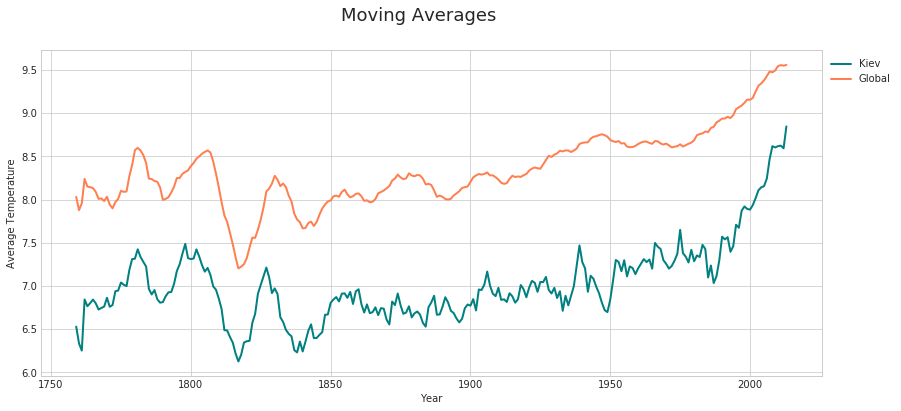

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
def plot_averages(data, title, cities, colors, col_names):
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots()
        fig.set_size_inches(14,6)
        for i in range(len(cities)):
            ax.plot(data.index, data[col_names[i]], colors[i], linewidth=2, label=cities[i])
#            ax.plot(data.index, data.global_temp, color='coral', linewidth=2, label='Global')
        ax.legend(bbox_to_anchor=(1, 1), loc=2)
        fig.suptitle(title, fontsize=18)
        plt.xlabel("Year")
        plt.ylabel("Average Temperature")
plot_averages(df_ma, "Moving Averages", ['Kiev', 'Global'], ['teal','coral'], ['kiev_temp', 'global_temp']) 

## Step 4: Observations (for Kiev and Global temperature)
1. The first observation that catches the eye is that it's definitely getting warmer. We see steady growth both in Ukraine and globally. 
2. There was a significant cooldown somewhere in the first quarter of the 19th century which was also the global trend. 
3. Based on these two graphs we can see that they are definitely correlated and that it might be the case that we will see somewhat similar shape if we take other cities. 
4. We can also notice that the range of fluctuations was bigger in 18th and 19th centuries, and up until 1870 (approximately) there was not a clear trend. So it looks like there was some factor that influenced the temperature all over the world and the first thing that comes to mind is anthropogenic factor. However, we can't state that, because correlation does not imply causation. 
5. Global temperature chart is much more unstable and we can note more fluctuations. However, it is hard to make any inferences since average is not a robust and it barely tells us something specific.

## Step 5: Additional exploration

I also decided to take another city - Moscow - and see how cold it it there in comparison to Kiev. The procedures are the same. The SQL is as follows:

SELECT cd.year, cd.avg_temp as moscow_avg  
FROM city_data cd  
WHERE cd.city = 'Moscow'  

Then we append it to the existing dataframe and re-calculate the moving average: 

In [37]:
moscow_temp = pd.read_csv("moscow_temp.csv")
df = pd.merge(moscow_temp, df, how='inner', left_on='year', right_on='year').set_index('year')
df_ma = df.rolling(N,N).mean()[N-1:]

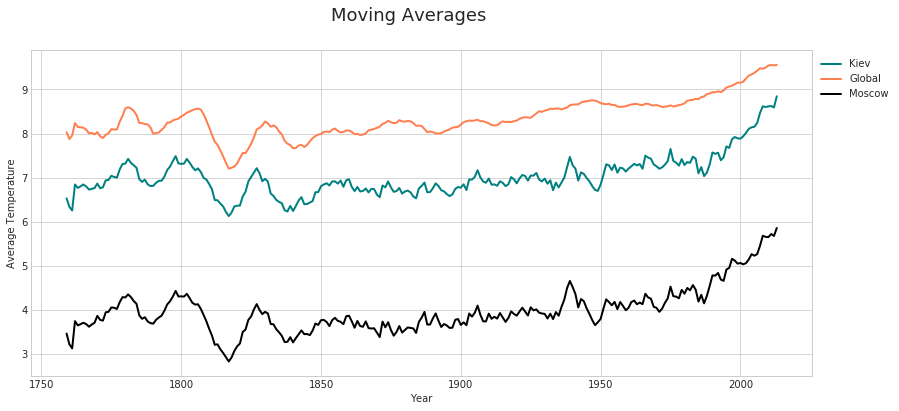

In [40]:
plot_averages(df_ma, "Moving Averages", ['Kiev', 'Global', 'Moscow'], 
              ['teal','coral', 'black'], ['kiev_temp', 'global_temp', 'moscow_temp']) 

As we can see, it is definitely colder in Moscow, even compared to Kiev! Another observation we can make is that Moscow is much more coherent with global trends. At this stage it makes sense to check the correlation coefficients. We can do that with numpy functions:

In [41]:
"Kiev and global: {}".format(np.round(np.corrcoef(df_ma.kiev_temp, df_ma.global_temp)[0,1],4))

'Kiev and global: 0.8806'

In [42]:
"Moscow and global: {}".format(np.round(np.corrcoef(df_ma.moscow_temp, df_ma.global_temp)[0,1],4))

'Moscow and global: 0.8985'

The simplest way to try to estimate loal temperature without creating a regression model is to calculate the average difference between global and local temperature which should work pretty well for Moscow since their graps are of almost identical shape: 

In [43]:
mean_deviation = np.round(np.mean(df_ma.global_temp-df_ma.moscow_temp),4)
"The mean deviation is: {}".format(mean_deviation)

'The mean deviation is: 4.3681'

In [44]:
moscow_predicted = df_ma.global_temp-mean_deviation

Now let's calculate the error of this prediction as a root mean squared error - subratact actual from predicte, raise to the power of two, find the average and take the square root

In [45]:
'RMSE: {}'.format(np.round(np.sqrt(np.mean((moscow_predicted-df_ma.moscow_temp)**2)),4))

'RMSE: 0.2293'